In [3]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

sys.path.insert(0, '../')

import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

from mnist_train import Net
from utils.gpu_utils import restrict_GPU_pytorch
from utils.imagenet_utils import accuracy
from utils.dataloading_utils import MyIter, MyLoader
from new_tta_models import ImageW, ImageS, ImageWS, Original, StandardTTA

restrict_GPU_pytorch('1')

Using GPU:0
Using GPU:1


In [14]:
def eval_agg_model(agg_model, dataloader):
    agg_model.eval()
    agg_model.cuda('cuda:0')
    model.cuda('cuda:0')
    test_acc1s = []
    test_acc5s = []
    for examples, target in dataloader:
        examples = examples.cuda('cuda:0', non_blocking=True)
        target = target.cuda('cuda:0', non_blocking=True)    
        output = agg_model(examples)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        test_acc1s.append(acc1.item())
        test_acc5s.append(acc5.item())
    return np.mean(test_acc1s), np.mean(test_acc5s)


def train_agg_model(model, n_augs, agg_model_name):
    if agg_model_name == 'image_s':
        agg_model = ImageS(model, 0, 1)
    elif agg_model_name == 'image_w':
        agg_model = ImageW(model,n_augs, 0, 1)
    elif agg_model_name == 'image_ws':
        agg_model = ImageWS(model,n_augs, 0, 1)

    agg_model = ImageS(model, 0, 1)
    agg_model.cuda('cuda:0')
    criterion = torch.nn.CrossEntropyLoss()
    criterion.cuda('cuda:0')
    optimizer = torch.optim.SGD(agg_model.parameters(), lr=.01, momentum=.9, weight_decay=1e-4)

    losses = []
    acc1s = []
    acc5s = []
    epochs = 10
    for epoch in tqdm(range(epochs)):
        epoch_loss = []
        for examples, target in data_loader:
            examples = examples.cuda('cuda:0', non_blocking=True)
            target = target.cuda('cuda:0', non_blocking=True)
            output = agg_model(examples)
            loss = criterion(output, target)
            acc1, acc5 = accuracy(output, target, topk=(1, 5))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            acc1s.append(acc1.item())
            acc5s.append(acc5.item())
        losses.append(np.mean(epoch_loss))
    return agg_model, losses, acc1s, acc5s

In [15]:
dataset = datasets.MNIST('../datasets', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
hflip_dataset = datasets.MNIST('../datasets', download=True, train=False, transform=transforms.Compose([
                           transforms.RandomHorizontalFlip(p=1),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))
vflip_dataset = datasets.MNIST('../datasets', download=True, train=False, transform=transforms.Compose([
                           transforms.RandomVerticalFlip(p=1),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))

n_examples = len(dataset)
subset_indices = np.arange(n_examples)
np.random.shuffle(subset_indices)
val_idxs = subset_indices[:int(len(subset_indices)/2)]
test_idxs = subset_indices[int(len(subset_indices)/2):]
batch_size = 1024
n_augs = 2
orig_val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, val_idxs), 
        batch_size=batch_size, shuffle=False)
hflip_val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(hflip_dataset, val_idxs),
                                                batch_size=batch_size, shuffle=False)
vflip_val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(vflip_dataset, val_idxs),
                                                batch_size=batch_size, shuffle=False)
data_loader = MyLoader([orig_val_loader, hflip_val_loader])


orig_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, test_idxs), 
        batch_size=batch_size, shuffle=False)
hflip_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(hflip_dataset, test_idxs),
                                                batch_size=batch_size, shuffle=False)
vflip_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(vflip_dataset, test_idxs),
                                                batch_size=batch_size, shuffle=False)
test_data_loader = MyLoader([orig_test_loader, hflip_test_loader])

In [17]:
pcts = [.005, .01, .05, .075,  .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
results = []
for pct in tqdm(pcts):
    model = Net()
    model.load_state_dict(torch.load('../saved_models/mnist/mnist_cnn_' + str(pct) + '.pth'))
    model.eval()
    
    # Original model
    orig_model = Original(model, 0)
    orig_acc1, orig_acc5 = eval_agg_model(orig_model, test_data_loader)
    results.append({'agg_model': 'orig', 'pct': pct, 'acc1': orig_acc1, 'acc5': orig_acc5})
    # stta model
    stta_model = StandardTTA(model)
    stta_acc1, stta_acc5 = eval_agg_model(stta_model, test_data_loader)
    results.append({'agg_model': 'stta', 'pct': pct, 'acc1': stta_acc1, 'acc5': stta_acc5})
    
    # image to s 
    s_model, losses, acc1s, acc5s = train_agg_model(model, n_augs, 'image_s')
    acc1, acc5 = eval_agg_model(s_model, test_data_loader)
    results.append({'agg_model': 'image_s', 'pct': pct, 'acc1': acc1, 'acc5': acc5})

    # image to w 
    w_model, losses, acc1s, acc5s = train_agg_model(model, n_augs, 'image_w')
    acc1, acc5 = eval_agg_model(w_model, test_data_loader)
    results.append({'agg_model': 'image_w', 'pct': pct, 'acc1': acc1, 'acc5': acc5})

    # image to s and w 
    ws_model, losses, acc1s, acc5s = train_agg_model(model, n_augs, 'image_ws')
    acc1, acc5 = eval_agg_model(ws_model, test_data_loader)
    results.append({'agg_model': 'image_ws', 'pct': pct, 'acc1': acc1, 'acc5': acc5})
results_df = pd.DataFrame(results)


<AxesSubplot:xlabel='pct', ylabel='acc1'>

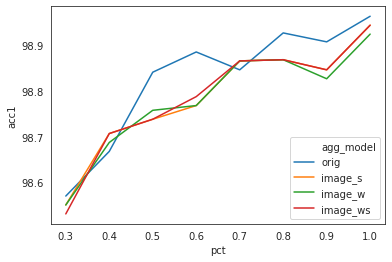

In [24]:
import pandas as pd
import seaborn as sns
sns.set_style('white')
non_stta = results_df[results_df['agg_model'] != 'stta']
non_stta = non_stta[non_stta['pct'] > .2]
sns.lineplot(x='pct', y='acc1', hue='agg_model', data=non_stta)

# Original Model

91.28595123291015 99.44275512695313


# Training Image --> S 

In [68]:
def eval_agg_model(agg_model, dataloader):
    agg_model.eval()
    agg_model.cuda('cuda:0')
    model.cuda('cuda:0')
    test_acc1s = []
    test_acc5s = []
    for examples, target in dataloader:
        examples = examples.cuda('cuda:0', non_blocking=True)
        target = target.cuda('cuda:0', non_blocking=True)    
        output = agg_model(examples)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        test_acc1s.append(acc1.item())
        test_acc5s.append(acc5.item())
    return np.mean(test_acc1s), np.mean(test_acc5s)

91.24688873291015 99.46228637695313


# Training Image --> W 

In [70]:
def train_image_to_w(model, n_augs):
    w_model = ImageW(model,n_augs, 0, 1)
    w_model.cuda('cuda:0')
    criterion = torch.nn.CrossEntropyLoss()
    criterion.cuda('cuda:0')
    optimizer = torch.optim.SGD(w_model.parameters(), lr=.01, momentum=.9, weight_decay=1e-4)


    losses = []
    acc1s = []
    acc5s = []
    epochs = 10
    for epoch in tqdm(range(epochs)):
        for examples, target in data_loader:
            examples = examples.cuda('cuda:0', non_blocking=True)
            target = target.cuda('cuda:0', non_blocking=True)
            output = w_model(examples)
            loss = criterion(output, target)
            acc1, acc5 = accuracy(output, target, topk=(1, 5))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            acc1s.append(acc1.item())
            acc5s.append(acc5.item())
    return w_model, losses, acc1s, acc5s

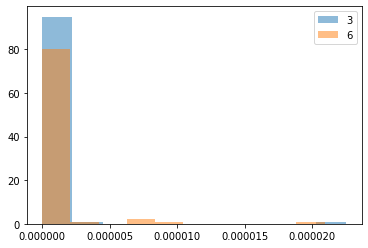

In [72]:
w_vals = w_model.get_w(examples).detach().cpu().numpy()
first_num = 3
second_num = 6
first_idxs = np.where(target.detach().cpu().numpy()== first_num)[0]
second_idxs = np.where(target.detach().cpu().numpy()== second_num)[0]
plt.hist(w_vals[:,1][first_idxs], alpha=.5, label=str(first_num))
plt.hist(w_vals[:,1][second_idxs], alpha=.5, label=str(second_num))
plt.legend()

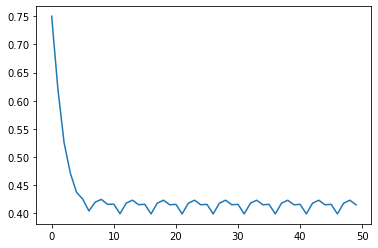

In [73]:
plt.plot(losses)

# Training Image --> W, S

In [74]:
def train_image_to_ws(model, n_augs):
    ws_model = ImageWS(model,n_augs, 0, 1)
    ws_model.cuda('cuda:0')
    criterion = torch.nn.CrossEntropyLoss()
    criterion.cuda('cuda:0')
    optimizer = torch.optim.SGD(ws_model.parameters(), lr=.01, momentum=.9, weight_decay=1e-4)


    losses = []
    acc1s = []
    acc5s = []
    epochs = 25
    for epoch in tqdm(range(epochs)):
        for examples, target in data_loader:
            examples = examples.cuda('cuda:0', non_blocking=True)
            target = target.cuda('cuda:0', non_blocking=True)
            output = ws_model(examples)
            loss = criterion(output, target)
            acc1, acc5 = accuracy(output, target, topk=(1, 5))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            acc1s.append(acc1.item())
            acc5s.append(acc5.item())
    return ws_model, losses, acc1s, acc5s

In [75]:
ws_model.eval()
ws_model.cuda('cuda:0')
test_acc1s = []
test_acc5s = []
for examples, target in test_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = ws_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
print(np.mean(test_acc1s), np.mean(test_acc5s))

91.28595123291015 99.44275512695313


In [76]:
ws_model.get_sw(examples)

(tensor([[0.0020],
         [0.0075],
         [0.0047],
         [0.0202],
         [0.0029],
         [0.0165],
         [0.0037],
         [0.0022],
         [0.0056],
         [0.0032],
         [0.0198],
         [0.0051],
         [0.0158],
         [0.0055],
         [0.0078],
         [0.0247],
         [0.0125],
         [0.0028],
         [0.0362],
         [0.0044],
         [0.0088],
         [0.0128],
         [0.0139],
         [0.0105],
         [0.0154],
         [0.0147],
         [0.0059],
         [0.0027],
         [0.0019],
         [0.0078],
         [0.0077],
         [0.0053],
         [0.0125],
         [0.0040],
         [0.0066],
         [0.0281],
         [0.0064],
         [0.0037],
         [0.0096],
         [0.0157],
         [0.0037],
         [0.0032],
         [0.0013],
         [0.0151],
         [0.0120],
         [0.0061],
         [0.0067],
         [0.0087],
         [0.0102],
         [0.0014],
         [0.0117],
         [0.0019],
         [0.

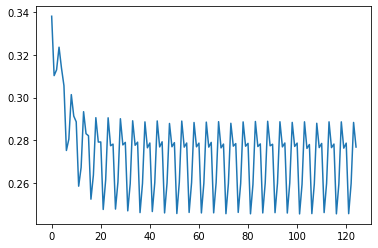

In [77]:
plt.plot(losses)